# Mid Price Encoder

В мид прайс энкодере мы вначале преобразуем приращения мид прайса в целые числа:
$$
\Delta M = \text{round}\left(\dfrac{\Delta M}{h}\right)
$$
где $h$ -- шаг дискритезации. Если агрегации по уровням нет, то разумно положить $h = 0.5 \text{tick_size}$. Если есть агрегация, то шаг изменения $\Delta M$ становится меньше. Для биткоина я положил $h = 0.01$, возможно для эфира нужно взять меньше.

В силу симметрии, достаточно уметь кодировать положительные значения $\Delta M$. Пусть $f(\Delta M)$ -- функция, которая кодирует изменения мид. прайса, определённая для $\Delta M > 0$. Доопределим её следующим образом:
$$
f(\Delta M) = \begin{cases}
    0, &\Delta M = 0 \\
    -f(-\Delta M), &\Delta M < 0
\end{cases}
$$

Введём сетку $0 = x_0 < x_1 < \ldots < x_N = \infty$. Положим:
$$
f(x) = \text{median} \left(  \Delta M_i :  x_k \leq \Delta M_i < x_{k+1} \right), \text{if } x_k \leq x < x_{k+1}
$$

Т.е. для каждой точки $x$ мы находим отрезок $[x_k, x_{k+1})$ к которому она пренадлежит и кодируем $x$ медианным значением из точек выборки, лежащих в этом отрезке.

Границы $x_k$ будем подбирать таким образом, чтобы всего было заданное число отрезков $n_{bin}$ и в каждом было примерно одинаково элементов выборки. 

В конце(при предикте) нужно будет домножить результат на $h$, чтобы результат был того же масштаба, что и входные данные.

# Spread encoder

Здесь я действовал примерно также, как и для $\Delta M$. Вначале мы переходим к целым значениям по формуле:
$$
S = \text{round} \left( \dfrac{S}{\text{ticksize}}\right)
$$

В `UniformSpreadEncoder` есть два параметра $\text{nbins}_1, \text{nbins}_2$. Первые $\text{nbins}_1$ значений мы кодируем ими же, оставшиеся значения разбиваем на $\text{nbins}_2$ бинов по схеме выше.

В `SpreadEncoder` бины выглядят примерно следующим образом:

 1 -> 2 -> 3 -> 4 -> 5 -> 7 -> 9 -> 11 -> 13 -> 18 -> 23 -> 28 -> 33 -> ...
 
т.е. вначале бины идут с шагом 1, потом с шагом 3, потом с шагом 5 и так до тех пор, пока мы не покроем все значения спреда до 0.99 квантили.

# Imbalance encoder

Здесь всё просто. $I \in [0, 1]$, поэтому функцию, кодирующую imbalance можно задать как:
$$
f(I) = \text{round}( I \cdot n_{imb} ) \in \{0, 1, \ldots, n_{imb} \}
$$где $n_{imb}$ -- желаемое число дискретизации. Я брал 10, 20.

In [1]:
from sys import path

path.append('/home/alex/anaconda3/lib/python3.9/site-packages')
path.append('../simulator/')

In [2]:
from load_data import load_before_time

from spread_encoder import SpreadEncoder
from mid_price_encoder import MidPriceEncoder, DummyMidPriceEncoder
from encoder import Encoder
from micro_price import SimpleMicroPrice, DummyMicroPrice

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter

import plotly.express as px

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
PATH_TO_FILE = '../md/btcusdt:Binance:LinearPerpetual/'
T = pd.Timedelta(120, 'm').delta

In [6]:
def agg_data(lobs, n_layers):
    """
        aggregate data from given number of layers
    """
    ask_prices = [ lobs[f'ask_price_{i}'].values for i in range(10)]
    bid_prices = [ lobs[f'bid_price_{i}'].values for i in range(10)]

    ask_vols = [ lobs[f'ask_vol_{i}'].values for i in range(10)]
    bid_vols = [ lobs[f'bid_vol_{i}'].values for i in range(10)]
    
    N = len(lobs)
    
    ask_price = np.zeros((N, ))
    bid_price = np.zeros((N, ))

    ask_vol = np.zeros((N, ))
    bid_vol = np.zeros((N, ))
    for i in range(n_layers):
        ask_vol += ask_vols[i]
        bid_vol += bid_vols[i]

        ask_price += ask_vols[i] * ask_prices[i]
        bid_price += bid_vols[i] * bid_prices[i]

    ask_price /= ask_vol
    bid_price /= bid_vol
    
    return ask_price, bid_price, ask_vol, bid_vol

In [7]:
lobs = load_before_time(PATH_TO_FILE + 'lobs.csv', T)

names = lobs.columns.values
ln = len('btcusdt:Binance:LinearPerpetual_')
renamer = { name:name[ln:] for name in names[2:]}
renamer[' exchange_ts'] = 'exchange_ts'
lobs.rename(renamer, axis=1, inplace=True)
lobs.drop(['exchange_ts'], axis=1, inplace=True)

lobs.receive_ts = pd.to_datetime(lobs.receive_ts)
lobs.set_index('receive_ts', drop=True, inplace=True)

In [8]:
lobs.head(5)

,ask_price_0,ask_vol_0,bid_price_0,bid_vol_0,ask_price_1,ask_vol_1,bid_price_1,bid_vol_1,ask_price_2,ask_vol_2,...,bid_price_7,bid_vol_7,ask_price_8,ask_vol_8,bid_price_8,bid_vol_8,ask_price_9,ask_vol_9,bid_price_9,bid_vol_9
receive_ts,,,,,,,,,,,,,,,,,,,,,
2022-06-23 00:00:02.250125991,19977.5,0.079,19977.4,12.381,19977.8,0.003,19976.7,0.066,19977.9,0.003,...,19975.7,4.455,19980.1,0.01,19975.6,1.529,19980.2,0.01,19975.4,1.641
2022-06-23 00:00:02.657844605,19977.5,0.078,19977.4,12.381,19977.8,0.003,19977.3,0.126,19977.9,0.003,...,19975.9,0.246,19980.1,0.01,19975.8,0.686,19980.2,0.01,19975.7,4.455
2022-06-23 00:00:03.346968722,19977.5,0.079,19977.4,12.381,19977.8,0.003,19977.3,0.126,19977.9,0.003,...,19975.9,0.246,19980.1,0.01,19975.8,0.686,19980.2,0.01,19975.7,4.455
2022-06-23 00:00:04.080791047,19977.5,0.079,19977.4,12.381,19977.8,0.003,19977.3,0.126,19977.9,0.003,...,19975.9,0.246,19980.1,0.01,19975.8,0.686,19980.2,0.01,19975.7,4.455
2022-06-23 00:00:04.452706766,19977.5,0.079,19977.4,12.381,19977.8,0.003,19977.3,0.126,19977.9,0.003,...,19975.9,0.246,19980.1,0.01,19975.8,0.686,19980.2,0.01,19975.7,4.455


In [9]:
rule = '100ms'

In [10]:
lobs = lobs.resample(rule='100ms').agg(lambda x:x[0] if len(x) else np.nan)

for i in range(1, len(lobs)):
    if np.isnan(lobs.ask_price_0.iloc[i]):
        lobs.iloc[i] = lobs.iloc[i - 1]

In [11]:
lobs.head(5)

,ask_price_0,ask_vol_0,bid_price_0,bid_vol_0,ask_price_1,ask_vol_1,bid_price_1,bid_vol_1,ask_price_2,ask_vol_2,...,bid_price_7,bid_vol_7,ask_price_8,ask_vol_8,bid_price_8,bid_vol_8,ask_price_9,ask_vol_9,bid_price_9,bid_vol_9
receive_ts,,,,,,,,,,,,,,,,,,,,,
2022-06-23 00:00:02.200,19977.5,0.079,19977.4,12.381,19977.8,0.003,19976.7,0.066,19977.9,0.003,...,19975.7,4.455,19980.1,0.01,19975.6,1.529,19980.2,0.01,19975.4,1.641
2022-06-23 00:00:02.300,19977.5,0.079,19977.4,12.381,19977.8,0.003,19976.7,0.066,19977.9,0.003,...,19975.7,4.455,19980.1,0.01,19975.6,1.529,19980.2,0.01,19975.4,1.641
2022-06-23 00:00:02.400,19977.5,0.079,19977.4,12.381,19977.8,0.003,19976.7,0.066,19977.9,0.003,...,19975.7,4.455,19980.1,0.01,19975.6,1.529,19980.2,0.01,19975.4,1.641
2022-06-23 00:00:02.500,19977.5,0.079,19977.4,12.381,19977.8,0.003,19976.7,0.066,19977.9,0.003,...,19975.7,4.455,19980.1,0.01,19975.6,1.529,19980.2,0.01,19975.4,1.641
2022-06-23 00:00:02.600,19977.5,0.078,19977.4,12.381,19977.8,0.003,19977.3,0.126,19977.9,0.003,...,19975.9,0.246,19980.1,0.01,19975.8,0.686,19980.2,0.01,19975.7,4.455


In [12]:
n_layers = 1

ask_price, bid_price, ask_vol, bid_vol = agg_data(lobs, n_layers)

mid_price = (ask_price + bid_price) / 2.0
spread    = (ask_price - bid_price)
imb      = (bid_vol) / (ask_vol + bid_vol)

dm = np.diff(mid_price)

In [13]:
lim = 10
log = True
hist_bins = 20

# Results

## Гистограммы закодированных dM для разных числов бинов.


Ниже представлены гистограммы исходной выборки $\{\Delta M_i\}$ и преобразованной $\{f(\Delta M_i)\}$ для разного числа бинов. Гистограмма в логарифмическом масштабе, так как в нормальном масштабе видны большие вплески вблизи нуля. Видно, что 50 и 100 бинов уже достаточно хорошо описывают исходную выборку. Стоит обратить внимание, что для 50 бинов гистограммы отличаются в хвостах, где плотность достаточно близка к нулю. Основную информацию несёт центральная часть гистограммы.

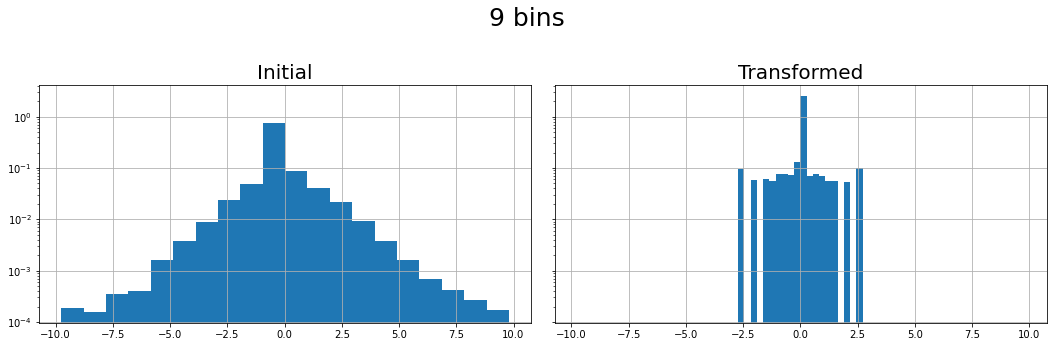

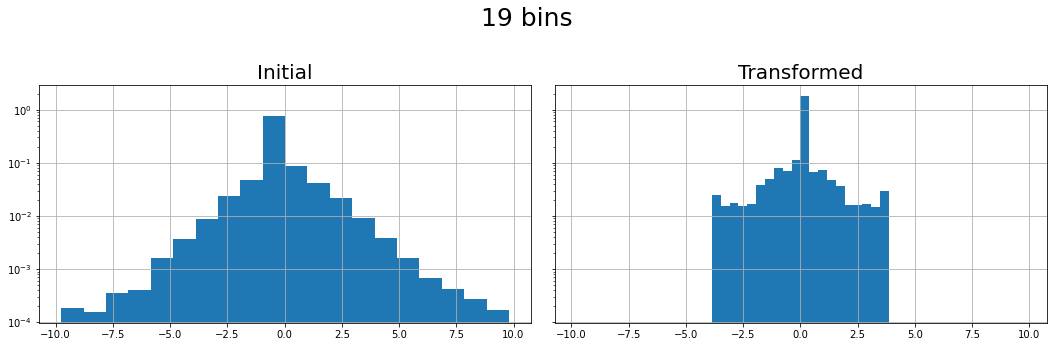

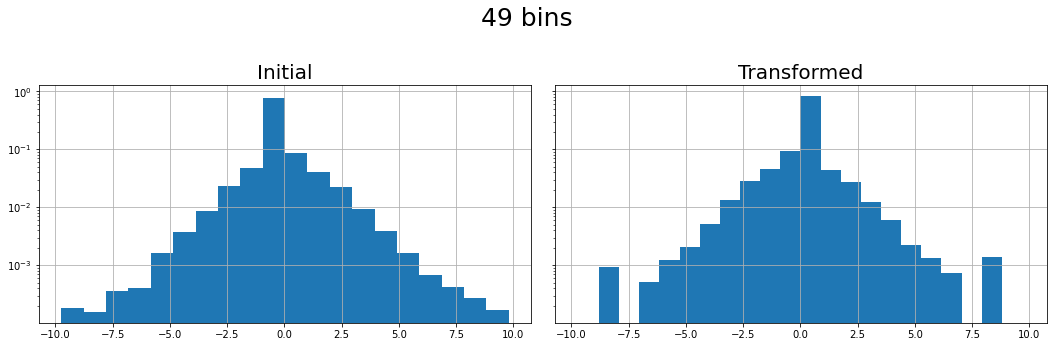

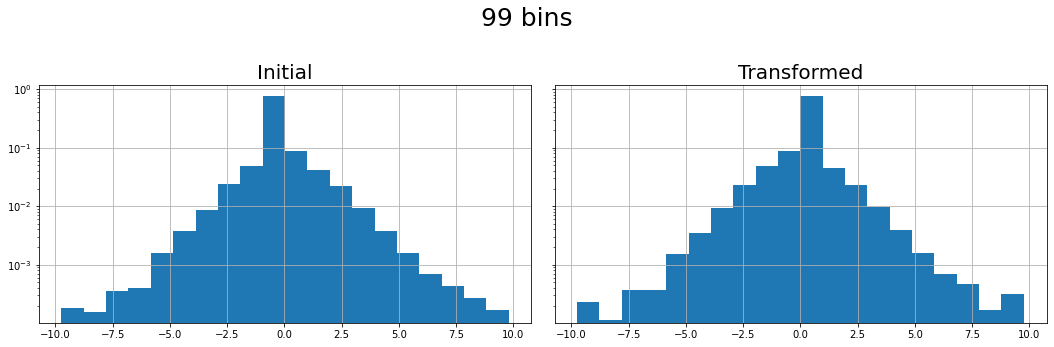

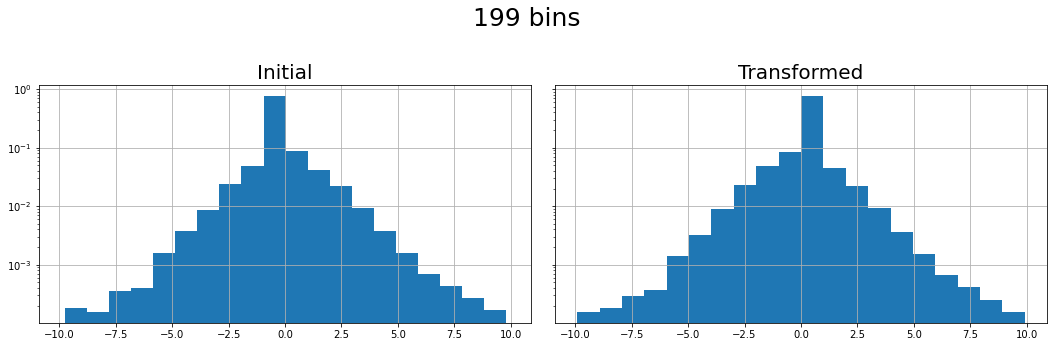

In [14]:
for n_bins in [10, 20, 50, 100, 200]:
    dm_encoder = MidPriceEncoder(n_bins=n_bins, tick_size=0.01)
    dm_encoder.fit(dm)
    dm_pr = dm_encoder.predict(dm)
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True, sharex=True)
    fig.suptitle(f"{dm_encoder.k_dm} bins", fontsize=25)
    ax[1].hist(dm_pr[(-lim <= dm_pr) &(dm_pr <= lim) ], bins=hist_bins, density=True, log=log)
    ax[1].grid(True)
    ax[1].set_title("Transformed", fontsize=20)

    ax[0].hist(dm[(-lim <= dm) &(dm <= lim) ], bins=hist_bins, density=True, log=log)
    ax[0].grid(True)
    ax[0].set_title("Initial", fontsize=20)
    plt.tight_layout(pad=2)
plt.show()

## Первые 20 уникальных значений $\Delta M$. Видно, что они идут с шагом 0.5, т.е. с шагом в пол тика

In [15]:
sorted(set(np.abs(dm_encoder.dm_set)))[:20]

[0.0,
 0.05,
 0.1,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35000000000000003,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7000000000000001,
 0.75,
 0.8,
 0.85,
 0.9,
 0.9500000000000001]

## Тоже самое, но после усреднения по 3 уровням.


Ниже представлены гистограммы исходной выборки $\{\Delta M_i\}$ и преобразованной $\{f(\Delta M_i)\}$ для разного числа бинов после усреднения по 3 уровням. Видно, что чтобы описать истинную гистограмму нужно большее число бинов, так как они идут с меньшим шагом. 99 бинов выглядят норм.

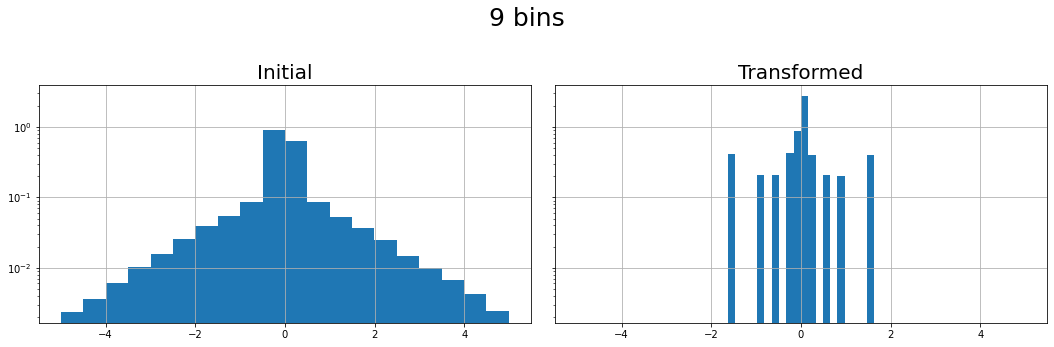

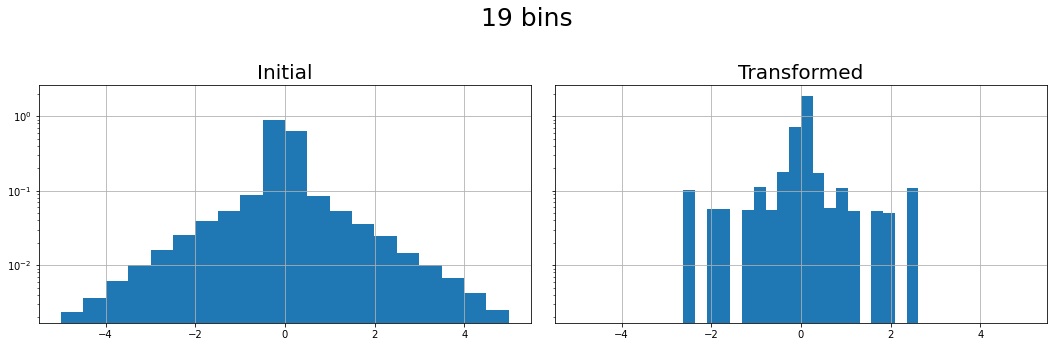

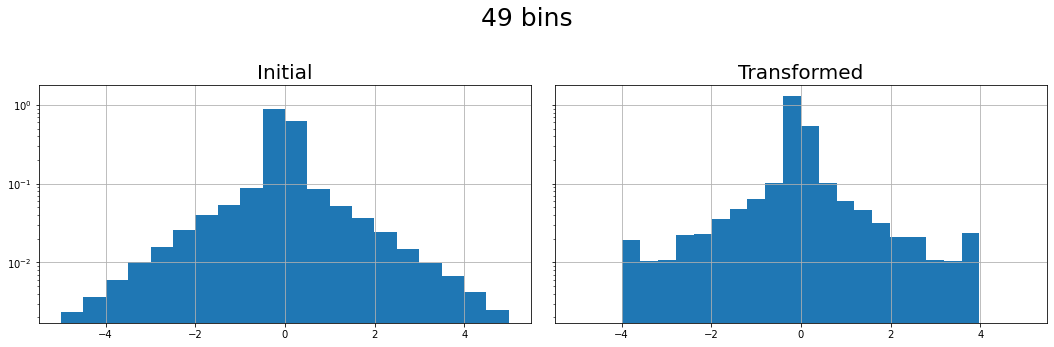

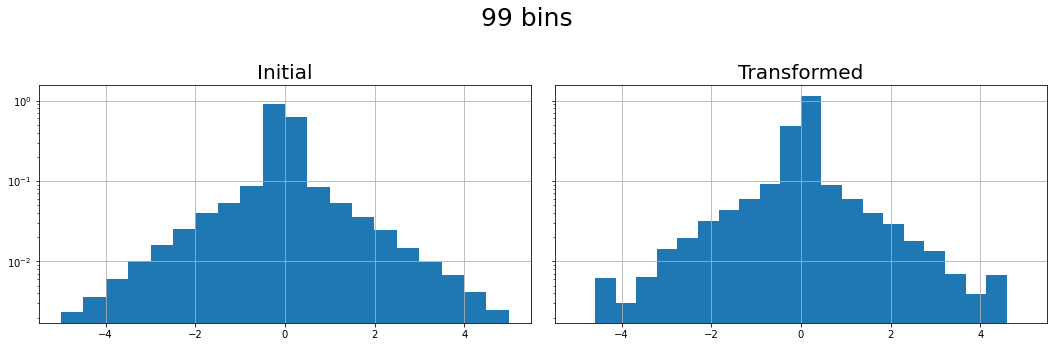

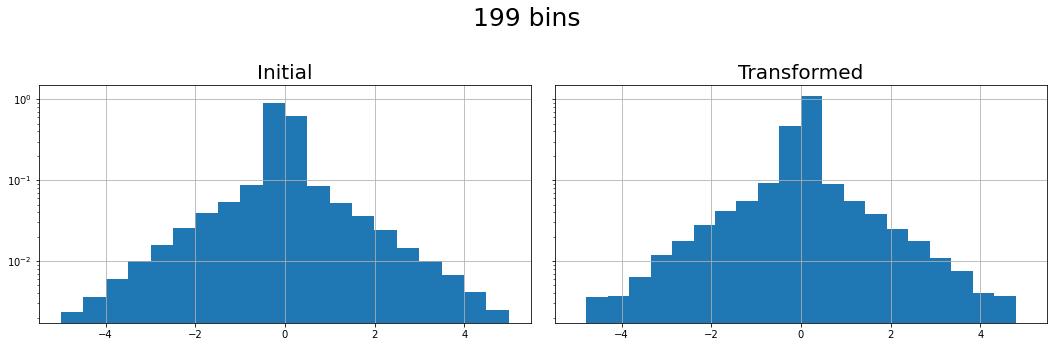

In [16]:
n_layers = 3

ask_price, bid_price, ask_vol, bid_vol = agg_data(lobs, n_layers)

mid_price = (ask_price + bid_price) / 2.0
spread    = (ask_price - bid_price)
imb      = (bid_vol) / (ask_vol + bid_vol)

dm = np.diff(mid_price)


lim = 5
log = True
hist_bins = 20


for n_bins in [10, 20, 50, 100, 200]:
    dm_encoder = MidPriceEncoder(n_bins=n_bins, tick_size=0.01)
    dm_encoder.fit(dm)
    dm_pr = dm_encoder.predict(dm)
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True, sharex=True)
    fig.suptitle(f"{dm_encoder.k_dm} bins", fontsize=25)
    ax[1].hist(dm_pr[(-lim <= dm_pr) &(dm_pr <= lim) ], bins=hist_bins, density=True, log=log)
    ax[1].grid(True)
    ax[1].set_title("Transformed", fontsize=20)

    ax[0].hist(dm[(-lim <= dm) &(dm <= lim) ], bins=hist_bins, density=True, log=log)
    ax[0].grid(True)
    ax[0].set_title("Initial", fontsize=20)
    plt.tight_layout(pad=2)
plt.show()

## Первые 20 уникальных значений $\Delta M$. Видно, что они идут с шагом 0.01, т.е. с маленьим шагом. Это эффект усреднения.

In [17]:
sorted(set(np.abs(dm_encoder.dm_set)))[:20]

[0.0,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1,
 0.11,
 0.12,
 0.13,
 0.14,
 0.15,
 0.16,
 0.17,
 0.18,
 0.19]

In [18]:
from spread_encoder import UniformSpreadEncoder

In [19]:
n_layers = 1

ask_price, bid_price, ask_vol, bid_vol = agg_data(lobs, n_layers)

mid_price = (ask_price + bid_price) / 2.0
spread    = (ask_price - bid_price)
imb      = (bid_vol) / (ask_vol + bid_vol)

dm = np.diff(mid_price)


lim = 5
log = True
hist_bins = 100

spread_encoder = UniformSpreadEncoder(tick_size=0.1, n_bins1=10, n_bins2=5)
spread_encoder.fit(spread)
spread_pr = spread_encoder.predict(spread)

In [20]:
lim = np.quantile(spread/0.1, 0.999)
log = True

## Гистограммы спреда для различных числов бинов.  UniformSpreadEncoder

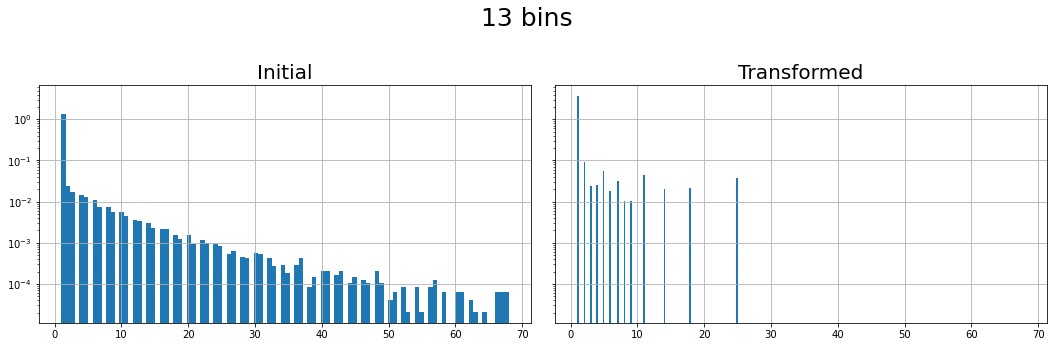

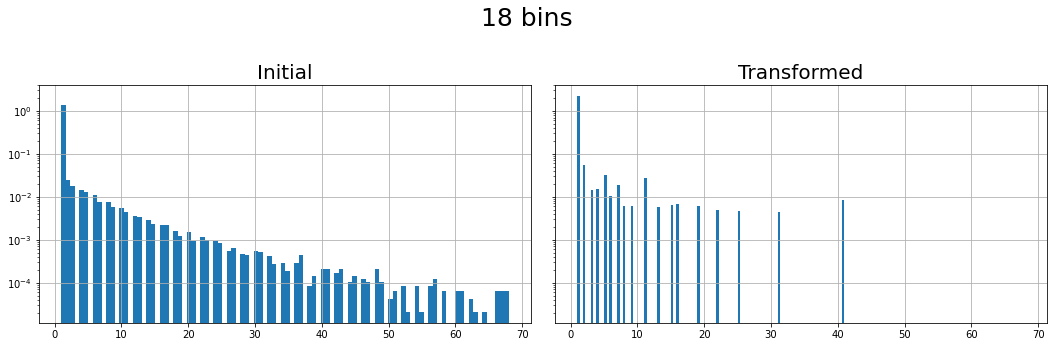

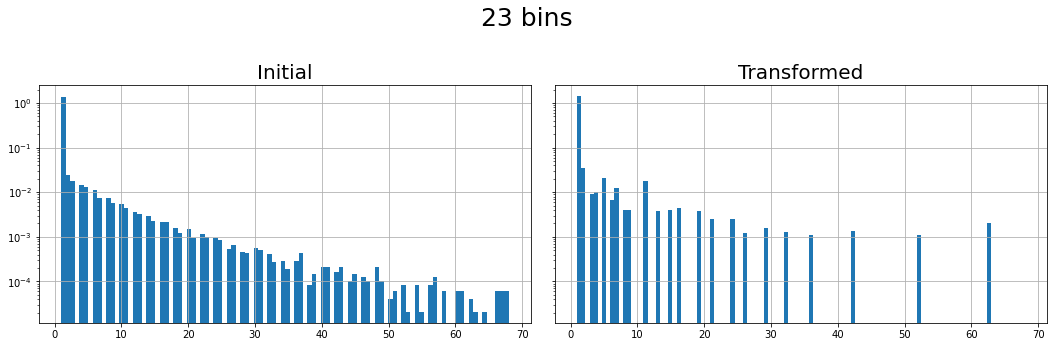

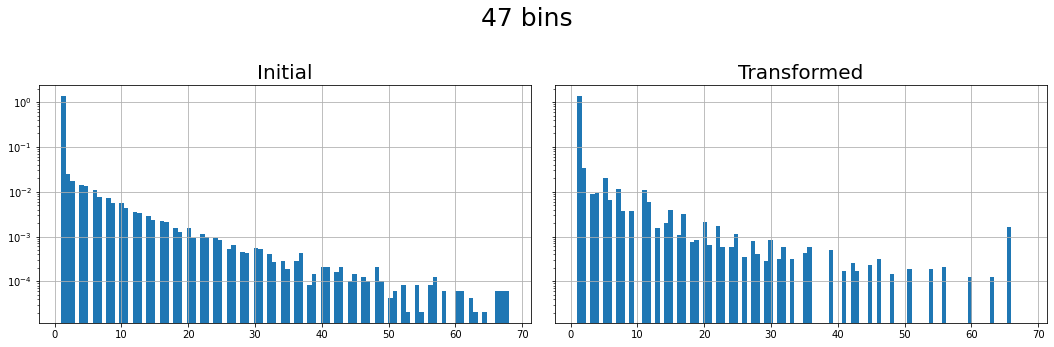

In [21]:
for n_bins2 in [5, 10, 15, 50]: 
    spread_encoder = UniformSpreadEncoder(tick_size=0.1, n_bins1=10, n_bins2=n_bins2)
    spread_encoder.fit(spread)
    spread_pr = spread_encoder.predict(spread)

    fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True, sharex=True)
    fig.suptitle(f"{spread_encoder.m_spread} bins", fontsize=25)
    ax[1].hist(spread_pr[spread_pr <= lim], bins=hist_bins, density=True, log=log)
    ax[1].grid(True)
    ax[1].set_title("Transformed", fontsize=20)

    ax[0].hist((spread / 0.1)[spread <= 0.1 * lim], bins=hist_bins, density=True, log=log)
    ax[0].grid(True)
    ax[0].set_title("Initial", fontsize=20)
    plt.tight_layout(pad=2)

plt.show()

## Тоже самое, но с усреднением по трём уровням

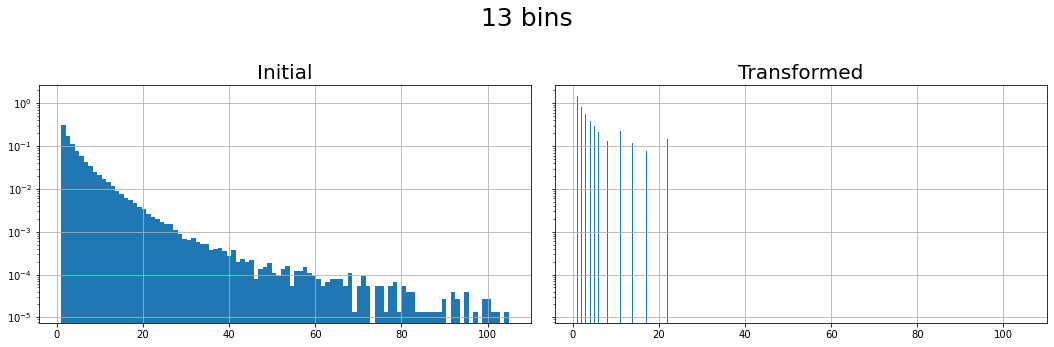

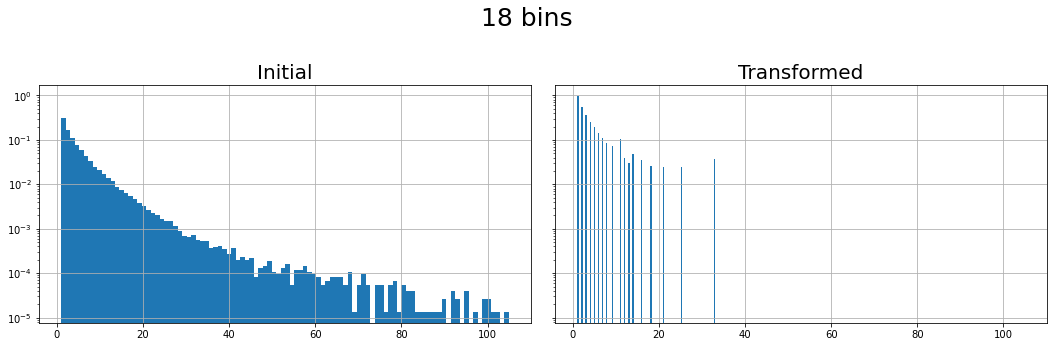

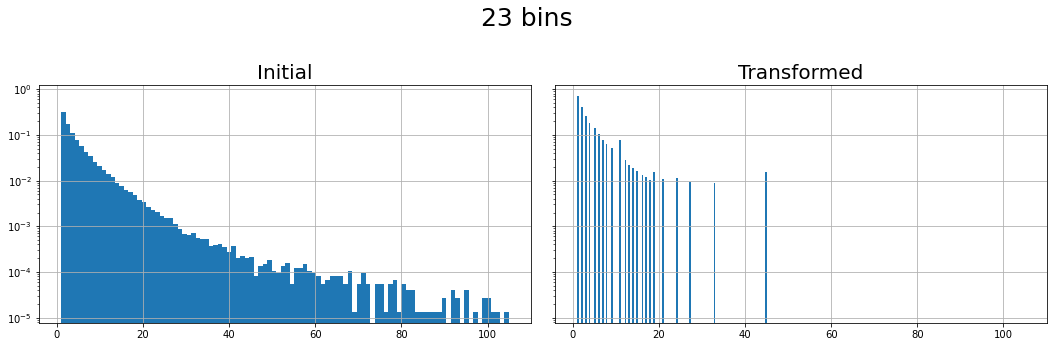

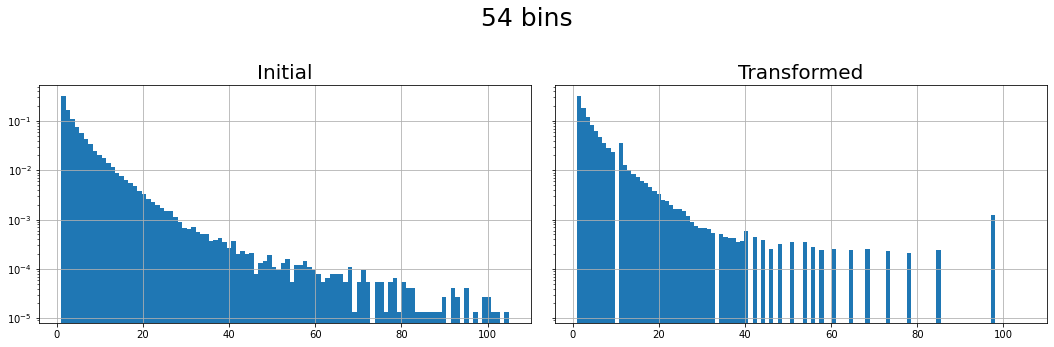

In [22]:
n_layers = 3

ask_price, bid_price, ask_vol, bid_vol = agg_data(lobs, n_layers)

mid_price = (ask_price + bid_price) / 2.0
spread    = (ask_price - bid_price)
imb      = (bid_vol) / (ask_vol + bid_vol)

dm = np.diff(mid_price)


lim = 5
log = True
hist_bins = 100

lim = np.quantile(spread/0.1, 0.999)
log = True

for n_bins2 in [5, 10, 15, 50]: 
    spread_encoder = UniformSpreadEncoder(tick_size=0.1, n_bins1=10, n_bins2=n_bins2)
    spread_encoder.fit(spread)
    spread_pr = spread_encoder.predict(spread)

    fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True, sharex=True)
    fig.suptitle(f"{spread_encoder.m_spread} bins", fontsize=25)
    ax[1].hist(spread_pr[spread_pr <= lim], bins=hist_bins, density=True, log=log)
    ax[1].grid(True)
    ax[1].set_title("Transformed", fontsize=20)

    ax[0].hist((spread / 0.1)[spread <= 0.1 * lim], bins=hist_bins, density=True, log=log)
    ax[0].grid(True)
    ax[0].set_title("Initial", fontsize=20)
    plt.tight_layout(pad=2)

plt.show()

## SpreadEncoder

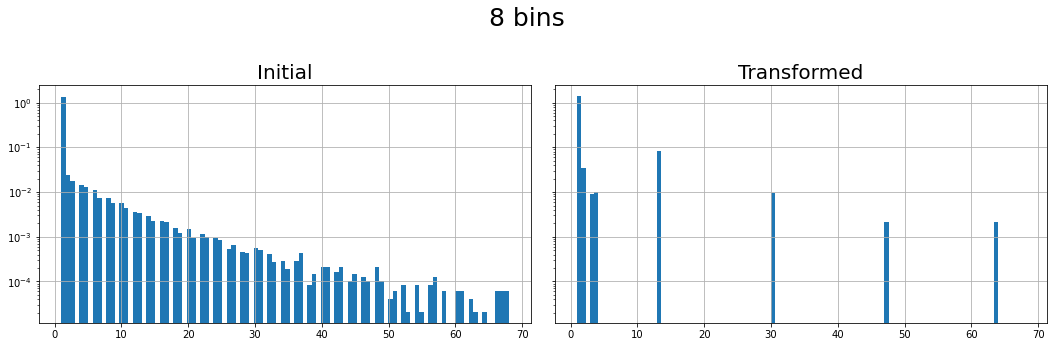

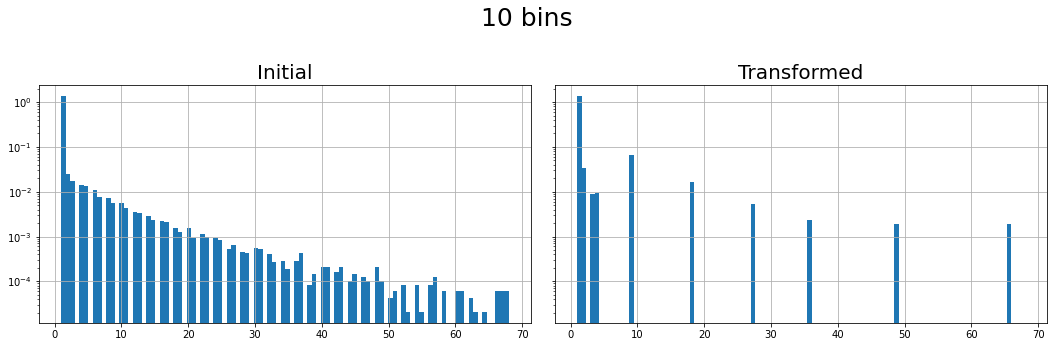

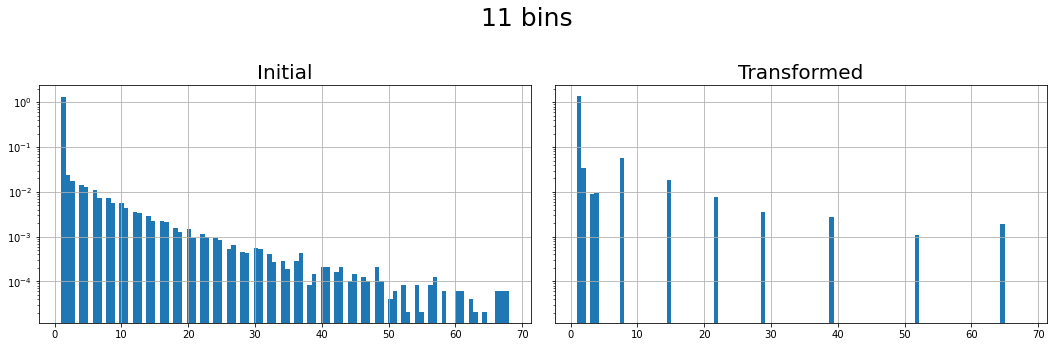

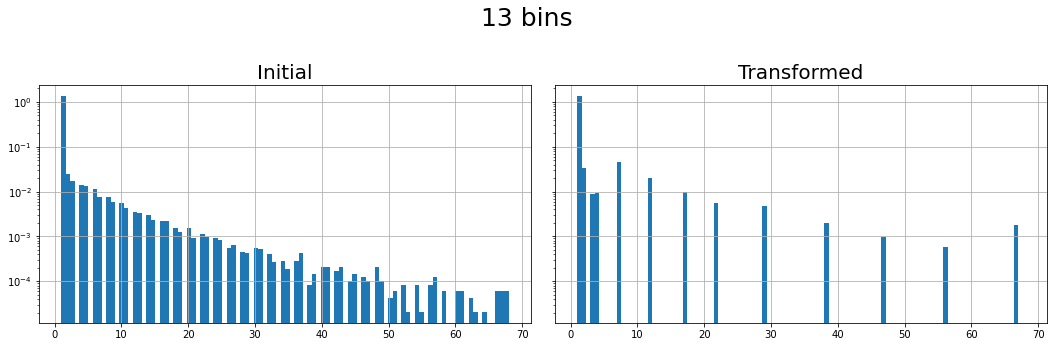

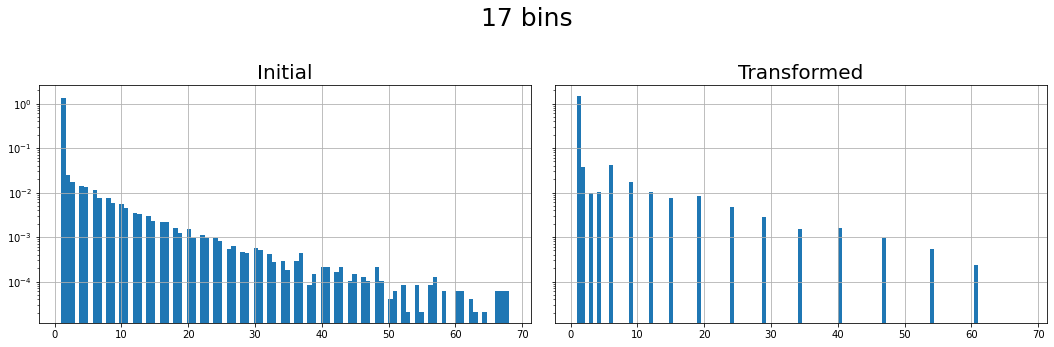

In [23]:
n_layers = 1

ask_price, bid_price, ask_vol, bid_vol = agg_data(lobs, n_layers)

mid_price = (ask_price + bid_price) / 2.0
spread    = (ask_price - bid_price)
imb      = (bid_vol) / (ask_vol + bid_vol)

dm = np.diff(mid_price)


lim = 5
log = True
hist_bins = 100

lim = np.quantile(spread/0.1, 0.999)
log = True

for step_inc in [16, 8, 6, 4, 2]: 
    spread_encoder = SpreadEncoder(tick_size=0.1, max_quantile=0.999, max_steps=4, step_inc=step_inc)
    spread_encoder.fit(spread)
    spread_pr = spread_encoder.predict(spread)

    fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True, sharex=True)
    fig.suptitle(f"{spread_encoder.m_spread} bins", fontsize=25)
    ax[1].hist(spread_pr[spread_pr <= lim], bins=hist_bins, density=True, log=log)
    ax[1].grid(True)
    ax[1].set_title("Transformed", fontsize=20)

    ax[0].hist((spread / 0.1)[spread <= 0.1 * lim], bins=hist_bins, density=True, log=log)
    ax[0].grid(True)
    ax[0].set_title("Initial", fontsize=20)
    plt.tight_layout(pad=2)

plt.show()

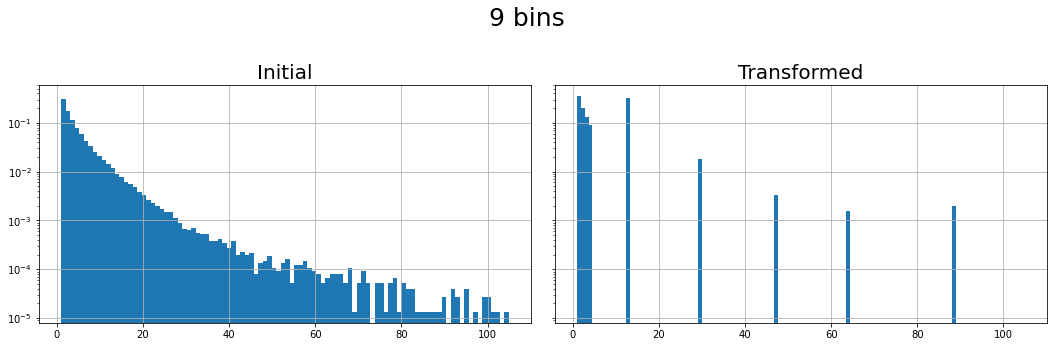

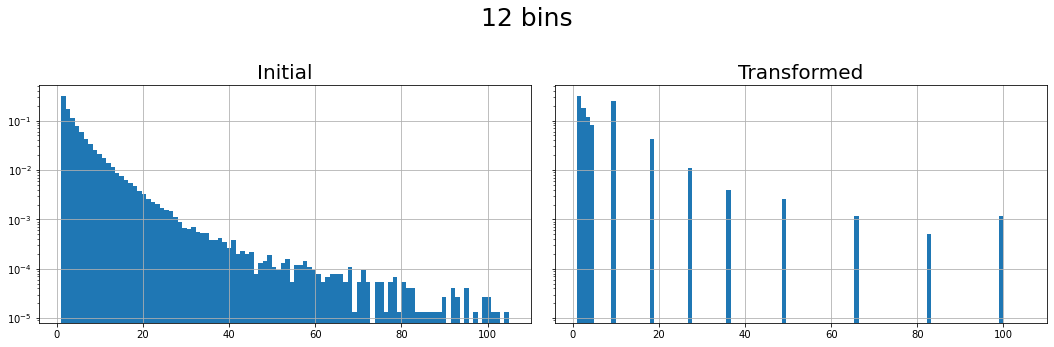

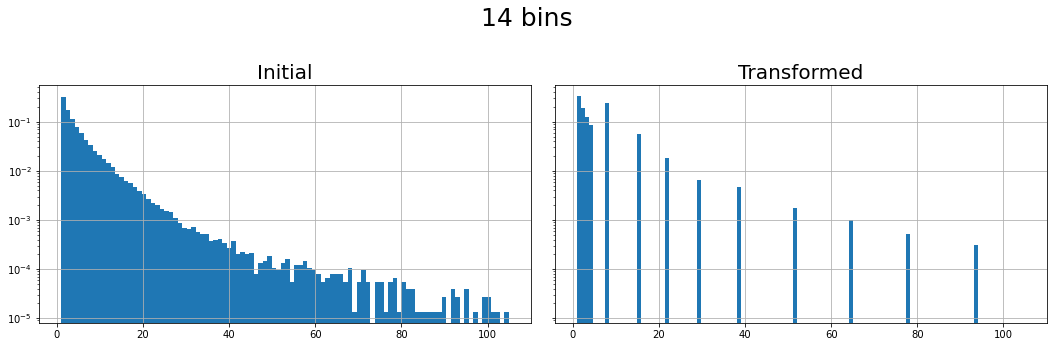

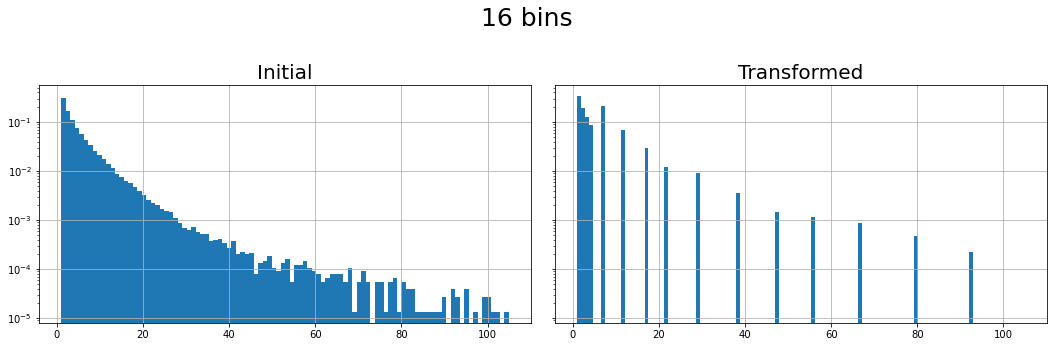

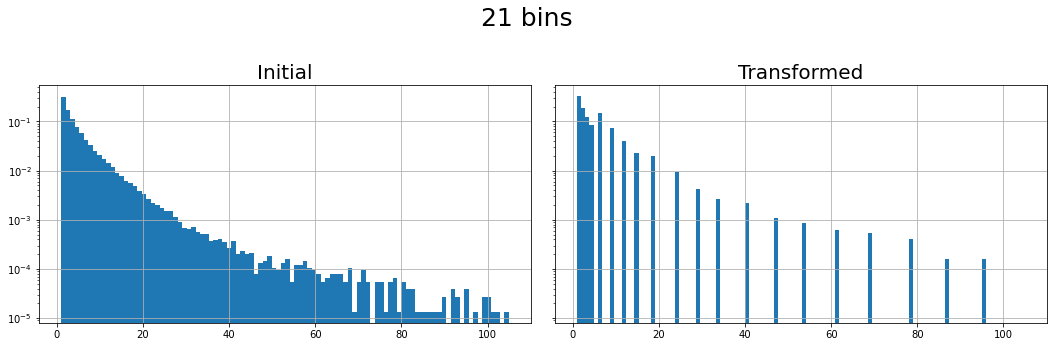

In [24]:
n_layers = 3

ask_price, bid_price, ask_vol, bid_vol = agg_data(lobs, n_layers)

mid_price = (ask_price + bid_price) / 2.0
spread    = (ask_price - bid_price)
imb      = (bid_vol) / (ask_vol + bid_vol)

dm = np.diff(mid_price)


lim = 5
log = True
hist_bins = 100

lim = np.quantile(spread/0.1, 0.999)
log = True

for step_inc in [16, 8, 6, 4, 2]: 
    spread_encoder = SpreadEncoder(tick_size=0.1, max_quantile=0.999, max_steps=4, step_inc=step_inc)
    spread_encoder.fit(spread)
    spread_pr = spread_encoder.predict(spread)

    fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True, sharex=True)
    fig.suptitle(f"{spread_encoder.m_spread} bins", fontsize=25)
    ax[1].hist(spread_pr[spread_pr <= lim], bins=hist_bins, density=True, log=log)
    ax[1].grid(True)
    ax[1].set_title("Transformed", fontsize=20)

    ax[0].hist((spread / 0.1)[spread <= 0.1 * lim], bins=hist_bins, density=True, log=log)
    ax[0].grid(True)
    ax[0].set_title("Initial", fontsize=20)
    plt.tight_layout(pad=2)

plt.show()

# Выводы

Видно, что методы ведут себя по разному: в UniformSpreadEncoder кодированные значения сконцентрированы в нуле, а в обычном SpreadEncoder они распределены + равномерно. В логарифмическом масштабе вторые графики выглядят красивее, но это может быть обманчивым, так как при втором кодировании каждому следующему бину соответствует малое число точек в исходной выборке, что не очень заметно в логарифмическом масштабе. Мне кажется, лучше отдать предпочтение первому энкодеру, ограничившись небольшим числом различных спредов.